In [1]:
import sys
sys.path.insert(1, '../')


In [2]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/Users/llja0112/repos/Uni-ACS/mimiciii_sepsis/../medical_explainer.py'>

In [3]:
import pandas as pd
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

seed = 7

data = pd.read_csv('mimiciii_sepsis.csv').drop(['Unnamed: 0', 'SUBJECT_ID', 'HADM_ID'], axis=1)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)

X = data.drop(['28 Day Death', 'In Hospital Death'], axis=1)
y = data['28 Day Death']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)

In [4]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

clf = GradientBoostingClassifier(n_estimators=220, max_depth=7, random_state=seed).fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.8661409295624043
Average Precision: 0.8219241002096367
Accuracy: 0.7907827359180688


In [6]:
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)
# explainer.plot_calibration_original()
# explainer.calibrate()
# explainer.plot_calibration_calibrated()


| Step 1  ==> Calibrating model


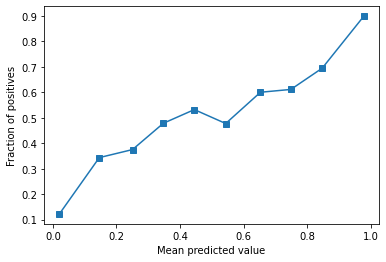

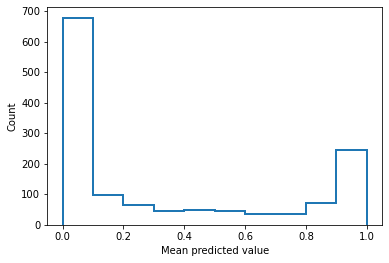

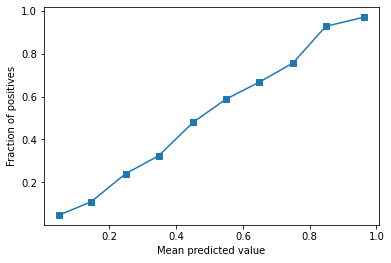

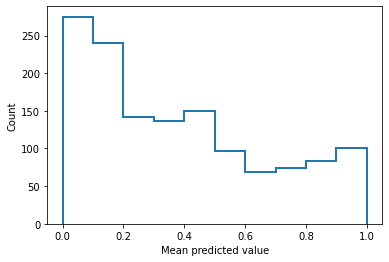

ROC AUC: 0.8661409295624043
Average Precision: 0.8219241002096367
Accuracy: 0.7907827359180688
ROC AUC: 0.8721160729658459
Average Precision: 0.8309396988913912
Accuracy: 0.7959034381858083

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 18.0

Probability threshold: 0.5
Score threshold: 29.0

Probability threshold: 0.9
Score threshold: 41.0



In [7]:
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='tree', method='novel')

In [12]:
explainer.variables

array(['LOS', 'RDW', 'ICU_LOS', 'Age', 'inotropes',
       'Lactate Dehydrogenase (LD)', 'Haptoglobin', 'Phosphate', 'ICUs',
       'Albumin'], dtype=object)

In [13]:
explainer.score_array_list

[array([ 8., -5.]),
 array([-3.,  4.]),
 array([ 1., -2.,  4.]),
 array([-2.,  3.]),
 array([-3.,  2.]),
 array([-2.,  1.]),
 array([ 2., -1.]),
 array([-1.,  1.]),
 array([ 0., -1.,  4.]),
 array([ 1., -1.])]

In [14]:
explainer.breakpoints_list

[[-0.3222222222222222, 8.420296637338277, 294.66041666666666],
 [11.6, 15.442368481276056, 30.5],
 [0.008, 0.043143496038710594, 5.281013550406813, 153.928],
 [18.258726899383984, 73.08052113237441, 90.0],
 [0.0, 0.9401474154387959, 3.0],
 [-8.271937990619335, 207.60238455174488, 23111.0],
 [-151.44629140606094, 158.81343669848746, 688.0],
 [0.2, 3.4487048423198887, 17.3],
 [0.0, 0.26254122009811004, 1.121022950650504, 5.0],
 [0.0, 2.7469765455333497, 18.290282613036652]]

In [138]:
explainer.shap_array_list

[[1.5291781698383364, -0.963797086131244],
 [-0.6201903318614885, 0.7059696672282467],
 [0.23995179218663898, -0.45610701118173846, 0.7266501559207539],
 [-0.4479241307229453, 0.6155798728278848],
 [-0.6238016993900682, 0.40539384523767996],
 [-0.39228346666276703, 0.11260212550780746],
 [0.4295790606166318, -0.1441696647595718],
 [-0.23281228079917562, 0.20754533417705534],
 [0.04476004641811287, -0.14015341536950057, 0.8183050155706296],
 [0.2493872206194356, -0.18932055521171443]]

In [15]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrtics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))

ROC AUC: 0.7432410084003154
Average Precision: 0.6392679031444433
Accuracy: 0.695683979517191
[[772  72]
 [344 179]]


In [25]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [30]:
from sklearn.utils import resample

auroc_array = []
auprc_array = []
accuracy_array = []

for i in range(50):
    X_test_bs = resample(X_test, n_samples=200, replace=False, stratify=y_test,
             random_state=i)
    y_test_bs = y_test[X_test_bs.index]

    scores,probs,predictions = explainer.predict_calculator(X_test_bs, 1)
    auroc = roc_auc_score(y_test_bs, probs)
    auprc = average_precision_score(y_test_bs, probs)
    accuracy = accuracy_score(y_test_bs, predictions)
    
    auroc_array.append(auroc)
    auprc_array.append(auprc)
    accuracy_array.append(accuracy)
    

print(mean_confidence_interval(auroc_array))
print(mean_confidence_interval(auprc_array))
print(mean_confidence_interval(accuracy_array))

(0.7469063456868335, 0.7376555577417688, 0.7561571336318981)
(0.6471622941122264, 0.6342367766283696, 0.6600878115960831)
(0.6975999999999999, 0.6902457637156658, 0.704954236284334)


In [21]:
shap_values_df = pd.DataFrame(explainer.shap_values, columns=explainer.X_train.columns)

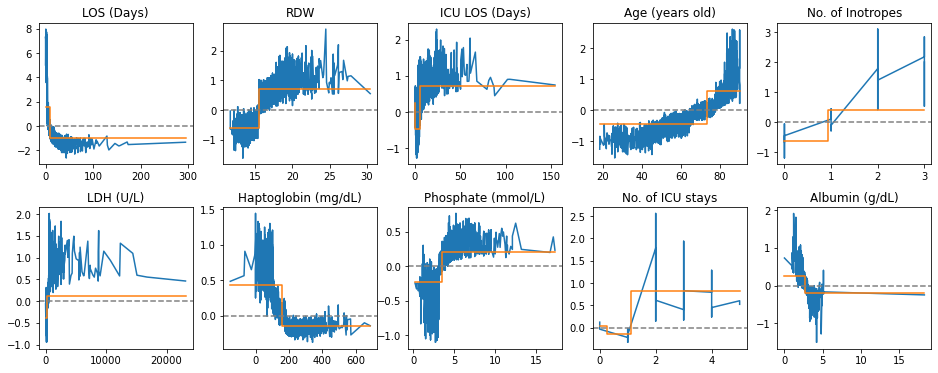

In [147]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

titles = ["LOS (Days)", "RDW", "ICU LOS (Days)", "Age (years old)", "No. of Inotropes",
         "LDH (U/L)", "Haptoglobin (mg/dL)", "Phosphate (mmol/L)", "No. of ICU stays", "Albumin (g/dL)"]
j = 0
for variable in explainer.variables:
    # print(variable)
    x = explainer.X_train[variable].values
    y = shap_values_df[variable].values

    y = y[np.argsort(x)]
    x = x[np.argsort(x)]

    score_x = []
    score_y = []
    
    i = 0
    #for score in explainer.score_array_list[j]:
    for score in explainer.shap_array_list[j]:
        score_x.append(explainer.breakpoints_list[j][i])
        score_y.append(score)
        score_x.append(explainer.breakpoints_list[j][i+1])
        score_y.append(score)
        i+=1

    #plt.subplots() 
    plt.subplot(2, 5, j+1)
    plt.plot(x, y, score_x, score_y)
    plt.axhline(0, linestyle='--', color='gray')
    plt.title(titles[j])
    j+=1

plt.subplots_adjust(hspace=0.3)
# plt.ylabel("SHAP values")
# plt.xlabel("Feature values")
plt.show()

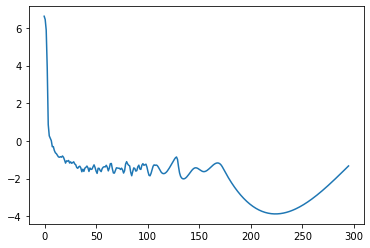

In [108]:
import matplotlib.pyplot as plt
import numpy as np
from csaps import csaps

x = explainer.X_train['LOS'].values
y = shap_values_df['LOS'].values

y = y[np.argsort(x)]
x = x[np.argsort(x)]

x_unique = np.unique(x)
y_unique = []
for xi in x_unique:
    y_unique.append(np.mean(y[np.where(x==xi)]))
    
y_unique = np.array(y_unique)

spline_sample_size = 300
xs = np.linspace(x_unique[0], x_unique[-1], spline_sample_size)
smoothing_result = csaps(x_unique, y_unique, xs, smooth=0.8)
ys = smoothing_result

plt.plot(xs, ys)

# plt.scatter(explainer.X_train['LOS'], shap_values_df['LOS'])


In [152]:
ordered_variables = explainer.X_train.columns[np.argsort(np.abs(explainer.shap_values.mean(0)))][::-1]

In [159]:
# from sklearn.model_selection import cross_validation
from sklearn.model_selection import cross_validate

clf = GradientBoostingClassifier(n_estimators=220, max_depth=7, random_state=seed)

scores = []

for i in range(len(ordered_variables)):
    results = cross_validate(clf, X_train[ordered_variables[:i+1]], y_train, cv=5, scoring="roc_auc")
    scores.append(np.mean(results['test_score']))
    print(ordered_variables[:i+1])
    print(results["test_score"])
    print()
    

Index(['LOS'], dtype='object')
[0.64157067 0.58560192 0.61511695 0.63754577 0.60441992]

Index(['LOS', 'ICU_LOS'], dtype='object')
[0.7068881  0.73885503 0.70038548 0.7099592  0.69373365]

Index(['LOS', 'ICU_LOS', 'ICUs'], dtype='object')
[0.73183801 0.74913268 0.73531802 0.73436552 0.70642327]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron'], dtype='object')
[0.73787461 0.77298536 0.75513882 0.74258814 0.74787112]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate'], dtype='object')
[0.76378454 0.76840131 0.77121425 0.76843812 0.74524532]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess'], dtype='object')
[0.78767009 0.79438454 0.77305829 0.77456847 0.76365729]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW'], dtype='object')
[0.78682486 0.80985571 0.77759025 0.78487289 0.78947589]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12'],
      dtype='object')
[0.79906503 0.80282336 0.78130958 0.781023

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2'],
      dtype='object')
[0.83861341 0.82823358 0.83501589 0.828957   0.85453499]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', '

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes'],
      dtype='object')
[0.84354913 0.83019222 0.84801792 0.833152   0.85294487]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect'

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals'],
      dtype='object')
[0.85409884 0.83091108 0.83926655 0.83120619 0.84264044]

Index

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals',
       'Creatine Kinase (CK)', 'Chloride, Whole Blood', 'INR(PT)', 'Monocytes',
      

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals',
       'Creatine Kinase (CK)', 'Chloride, Whole Blood', 'INR(PT)', 'Monocytes',
      

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals',
       'Creatine Kinase (CK)', 'Chloride, Whole Blood', 'INR(PT)', 'Monocytes',
      

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals',
       'Creatine Kinase (CK)', 'Chloride, Whole Blood', 'INR(PT)', 'Monocytes',
      

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals',
       'Creatine Kinase (CK)', 'Chloride, Whole Blood', 'INR(PT)', 'Monocytes',
      

KeyboardInterrupt: 

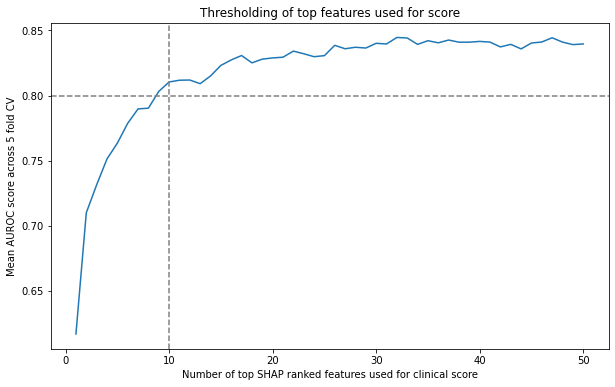

In [176]:
x = np.linspace(1, 50, 50)
plt.figure(figsize=(10, 6))
plt.plot(x, scores[:50])
plt.axhline(0.8, linestyle='--', color='gray')
plt.axvline(10, linestyle='--', color='gray')
plt.ylabel("Mean AUROC score across 5 fold CV")
plt.xlabel("Number of top SHAP ranked features used for clinical score")
plt.title("Thresholding of top features used for score")
plt.show()